In [138]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os

acropolis_directory = "../data"

In [139]:
df_new = pl.scan_parquet(os.path.join(acropolis_directory, "pivot_measurements.parquet"))
df_old = pl.scan_parquet(os.path.join(acropolis_directory, "old_db_renamed_measurements.parquet"))

df_new = df_new.select(["creation_timestamp","system_name", "cal_gmp343_filtered", "cal_bottle_id",]) \
.with_columns(pl.col("creation_timestamp").dt.cast_time_unit("us"))
df_old = df_old.select(["creation_timestamp","system_name", "cal_gmp343_filtered", "cal_bottle_id",]) \
.with_columns(pl.col("creation_timestamp").dt.cast_time_unit("us"))

df = pl.concat([df_new, df_old]).sort("creation_timestamp")


In [140]:
df = df.with_columns([pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_800"),
                      pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_800")])

In [141]:
dfg = df.groupby([pl.col("creation_timestamp").dt.date(), pl.col("system_name")]).agg([pl.col("cal_400").drop_nulls(),
                                                                                    pl.col("cal_800").drop_nulls(),
                                                                                    pl.col("cal_bottle_id_400").drop_nulls().median(),
                                                                                    pl.col("cal_bottle_id_800").drop_nulls().median()])

In [142]:
def average_bottle(data):
    data = data.to_list()
    #2nd bottle
    if 50 < len(data) < 70:
        x = data[int(len(data)*0.3):int(len(data)*0.95)]
        return sum(x) / len(x)
    #1st bottle
    elif 70 < len(data) < 130:
        x = data[int(len(data)*0.5):int(len(data)*0.95)]
        return sum(x) / len(x)
    else:
        return 0.0

dfg = dfg.select([pl.col("creation_timestamp"),
            pl.col("system_name"),
            pl.col("cal_400").apply(lambda x: average_bottle(x)).alias("mean_cal_400"),
            pl.col("cal_800").apply(lambda x: average_bottle(x)).alias("mean_cal_800"),
            pl.col("cal_bottle_id_400"),
            pl.col("cal_bottle_id_800")
            ])

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800
date,str,f64,f64,f64,f64
2023-06-03,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-13,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-13,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-19,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-19,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-23,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-26,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-27,"""tum-esm-midcos…",0.0,0.0,35.0,null
2023-06-28,"""tum-esm-midcos…",0.0,820.953846,9.0,36.0


# Calculate slope and intercept

In [143]:
df_gas = pl.read_csv("../data/averaged_gases.csv")

In [144]:
def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    # 
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    # y_true = m * y_meas + t
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

def calc_slope(meas_400, meas_800, id_400, id_800):
    if (meas_400 == None) or (meas_800 == None):
        return None
    
    bottles_meas = [meas_400, meas_800]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== id_400)["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== id_800)["CO2_dry"][0]]

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)
    
    return slope

def calc_intercept(meas_400, meas_800, id_400, id_800):
    if (meas_400 == None) or (meas_800 == None):
        return None
    
    bottles_meas = [meas_400, meas_800]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== id_400)["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== id_800)["CO2_dry"][0]]

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)
    
    return intercept

dfg = dfg.sort(pl.col("creation_timestamp")) \
    .filter(pl.col("mean_cal_400") > 0.0 ) \
    .filter(pl.col("mean_cal_800") > 0.0 )

dfg = dfg.with_columns(pl.struct(['mean_cal_400','mean_cal_800','cal_bottle_id_400','cal_bottle_id_800']) \
    .apply(lambda x: calc_slope(x['mean_cal_400'],x['mean_cal_800'],x['cal_bottle_id_400'],x['cal_bottle_id_800'])) \
    .alias('slope'))

dfg = dfg.with_columns(pl.struct(['mean_cal_400','mean_cal_800','cal_bottle_id_400','cal_bottle_id_800']) \
    .apply(lambda x: calc_intercept(x['mean_cal_400'],x['mean_cal_800'],x['cal_bottle_id_400'],x['cal_bottle_id_800'])) \
    .alias('intercept'))

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800,slope,intercept
date,str,f64,f64,f64,f64,f64,f64
2023-06-28,"""tum-esm-midcos…",416.809259,799.892308,8.0,33.0,1.016285,-6.179632
2023-06-28,"""tum-esm-midcos…",404.709259,793.105128,26.0,37.0,1.027683,-12.864598
2023-06-29,"""tum-esm-midcos…",406.910256,814.192593,30.0,39.0,1.020376,-14.530464
2023-06-29,"""tum-esm-midcos…",402.45641,790.427778,26.0,37.0,1.028808,-11.001923
2023-06-29,"""tum-esm-midcos…",395.46,786.52963,22.0,35.0,1.027002,0.538111
2023-06-29,"""tum-esm-midcos…",391.7,792.483333,4.0,25.0,1.044115,-9.449069
2023-06-30,"""tum-esm-midcos…",391.077778,781.076923,22.0,35.0,1.029821,3.936232
2023-06-30,"""tum-esm-midcos…",416.248148,812.448718,9.0,36.0,-1.00711,1224.756668
2023-06-30,"""tum-esm-midcos…",405.661111,815.535897,30.0,39.0,1.013922,-10.637786


In [145]:
dfg.collect().write_parquet("../data/calibration_correction.parquet")

In [146]:
dfg_test = dfg.sort(pl.col("creation_timestamp")) \
    .filter(pl.col("system_name") == "tum-esm-midcost-raspi-2") \
    
dfg_test.collect().tail(5)

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800,slope,intercept
date,str,f64,f64,f64,f64,f64,f64
2023-09-20,"""tum-esm-midcos…",389.383333,777.212821,4.0,14.0,1.056597,-11.890525
2023-09-21,"""tum-esm-midcos…",388.709756,777.251852,4.0,14.0,1.054659,-10.42556
2023-10-12,"""tum-esm-midcos…",388.325926,776.166667,4.0,14.0,1.056566,-10.761366
2023-10-13,"""tum-esm-midcos…",390.105,778.864815,4.0,14.0,1.054068,-11.666653
2023-10-14,"""tum-esm-midcos…",389.67963,778.141026,4.0,14.0,1.054878,-11.533824


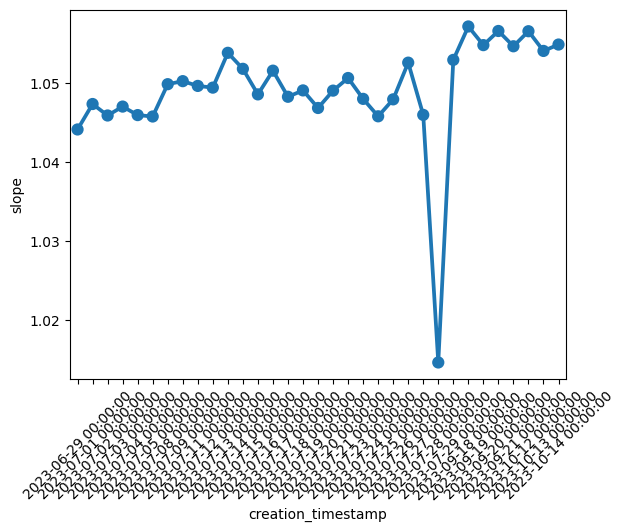

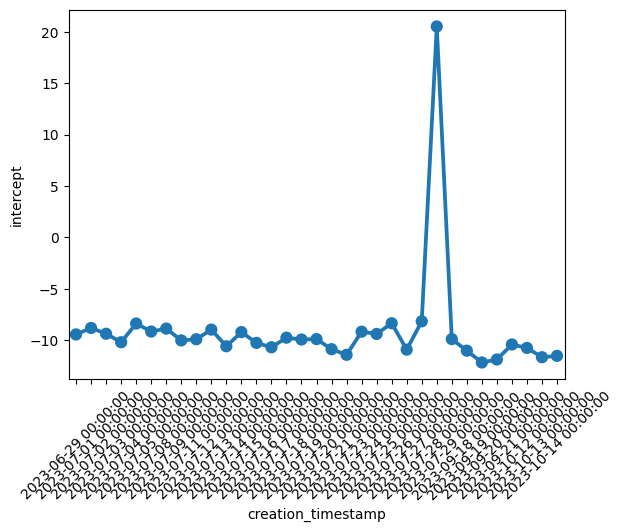

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="slope")
plt.xticks(rotation=45)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
plt.show()

sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="intercept")
plt.xticks(rotation=45)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
plt.show()
